# MLP for just the first cases

In [36]:
import torch 
import pandas as pd 
import pickle
import numpy as np
import os
import sys 

from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import trange

# Import weights & Biases
import wandb

sns.set_theme()

In [37]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import numpy as np

In [38]:
path = r'TF_HLC'

In [39]:
# Load data
freq_data = np.genfromtxt(os.path.join(path,"TTF_freq_1000.csv"), delimiter=",")

# Load pickle
with open(os.path.join(path,"TTF_data_1000.pt"), "rb") as f:
    TTF_data = pickle.load(f)

with open(os.path.join(path,"Vs_values_1000.pt"), "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)

TTF_data = TTF_data
Vs_data = Vs_data

print(TTF_data.shape, Vs_data.shape,freq_data.shape)


(1000, 1000) (1000, 29) (1000,)


In [40]:
def f0_calc(Vs):
    """
    Calculate f0 from Vs data
    """
    # First eliminate nans in axis 0
    Vs = np.nan_to_num(Vs, nan=0.0)
    Vs = np.trim_zeros(Vs, trim='b')
    vs_value_1 = Vs[0]
    vs_value_2 = Vs[-1]
    h_soil = len(Vs[:-1])*5

    # Calculate f0
    f0 = vs_value_1 / (4*h_soil)
    return f0

In [41]:
f0_vals = []
for i in range(Vs_data.shape[0]):
    f0 = f0_calc(Vs_data[i])
    f0_vals.append(f0)

f0_vals = np.array(f0_vals)

# Filter only if f0 < 5
idx = np.where(f0_vals < 2)[0]

# Filter
TTF_data = TTF_data[idx]
Vs_data = Vs_data[idx]

print(TTF_data.shape, Vs_data.shape,freq_data.shape)

(836, 1000) (836, 29) (1000,)


(array([169., 129., 105.,  91.,  68.,  66.,  67.,  50.,  49.,  42.]),
 array([100.05140816, 126.0362106 , 152.02101305, 178.00581549,
        203.99061794, 229.97542038, 255.96022283, 281.94502527,
        307.92982772, 333.91463016, 359.89943261]),
 <BarContainer object of 10 artists>)

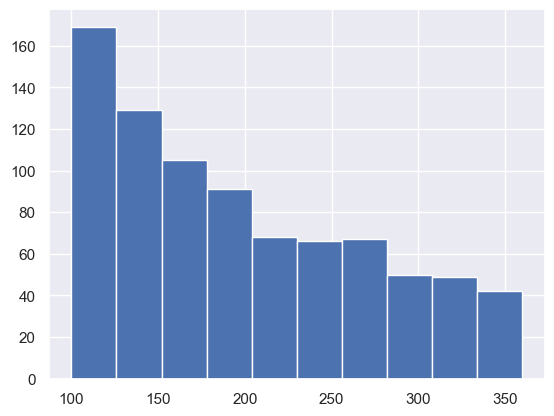

In [42]:
plt.hist(Vs_data[:,0])

In [43]:
# Convert all nan values to 0
Vs = np.nan_to_num(Vs_data, nan=0.0, posinf=0.0, neginf=0.0)

In [44]:
class TTF_dataset(Dataset):
    def __init__(self, TTF_values, Vs_values):
        self.TTF_values = TTF_values
        self.Vs_values = Vs_values
        
    def __len__(self):
        return len(self.TTF_values)
    
    def __getitem__(self, idx):

        input_data = np.nan_to_num(self.Vs_values[idx], nan=0.0, posinf=0.0, neginf=0.0)
        input_data = torch.tensor(input_data, dtype=torch.float32)

        target_data = self.TTF_values[idx]
        target_data = torch.tensor(target_data, dtype=torch.float32)
        return input_data, target_data

In [45]:
dataset = TTF_dataset(TTF_data, Vs_data)
print("Sizes in the dataset: ", len(dataset))
print("Data shapes for input and target: ", dataset[0][0].shape, dataset[0][1].shape)

# Separate into training and testing
train_size = int(0.5 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
print("Train, validation and test sizes: " , train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
print("Number of batches: ", len(train_loader), len(val_loader), len(test_loader))

Sizes in the dataset:  836
Data shapes for input and target:  torch.Size([29]) torch.Size([1000])
Train, validation and test sizes:  418 209 209
Number of batches:  5 3 3


In [46]:
X,y = next(iter(train_loader))
print(X.shape, y.shape)

torch.Size([100, 29]) torch.Size([100, 1000])


# Model

In [47]:
# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(True),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.ReLU(True),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Try with input
X_try = torch.randn(50, 29)
model = Autoencoder(input_dim=29, hidden_dim=64)
model(X_try).shape
    

torch.Size([50, 29])

In [48]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout_rate=0.2):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding='same')
        self.relu = nn.LeakyReLU(negative_slope=0.1)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding='same')
        self.dropout = nn.Dropout(dropout_rate)

        # Batch normalization
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # Add a 1x1 convolution to match dimensions if in_channels != out_channels
        self.residual_conv = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None


    def forward(self, x):
        residual = x
        x = self.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        
        # Adjust residual dimensions if necessary
        if self.residual_conv:
            residual = self.residual_conv(residual)

        return self.relu(x + residual)

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()
        self.modes = modes
        self.width = width
        self.scale = (1 / (width ** 0.5))
        self.weights = nn.Parameter(self.scale * torch.randn(modes, width, width, 2, dtype=torch.float))
        self.linear_transform = nn.Linear(width, width)
        self.activation = nn.ReLU()

    def forward(self, x):
        batchsize, length, width = x.shape

        # Compute Fourier transform
        x_ft = torch.fft.rfft(x, dim=1, norm='ortho')

        # Preallocate tensor
        self.out_ft = torch.zeros(batchsize, length // 2 + 1, width, dtype=torch.cfloat, device=x.device)

        # Keep only the lower modes
        modes = min(self.modes, length // 2)
        indices = torch.arange(0, modes, device=x.device)

        # Complex multiplication of the low frequency modes
        self.out_ft[:, indices, :] = self.compl_mul1d(x_ft[:, indices, :], torch.view_as_complex(self.weights))

        # Return to physical space
        x_fourier = torch.fft.irfft(self.out_ft, n=length, dim=1, norm='ortho')

        # Apply the linear transformation in physical space
        x_linear = self.linear_transform(x)

        return self.activation(x_fourier + x_linear)
        
    def compl_mul1d(self, input, weights):
        return torch.einsum("bmw,mwo->bmo", input, weights)
    

# Example usage
x = torch.randn(50, 200, 64)  # Example input tensor
modes = 10
width = 64

model = FNO1d(modes, width)
output = model(x)
print(output.shape)  # Output shape should be (50, 200, 64)
    

torch.Size([50, 200, 64])


In [50]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout_rate=0.2):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding='same')
        self.relu = nn.LeakyReLU(negative_slope=0.1)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding='same')
        self.dropout = nn.Dropout(dropout_rate)
        self.pool = nn.MaxPool1d(kernel_size=2)  # Add pooling to reduce spatial dimension

        # Batch normalization
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # Add a 1x1 convolution to match dimensions if in_channels != out_channels
        self.residual_conv = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        x = self.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.bn2(x)

        # Adjust residual dimensions if necessary
        if self.residual_conv:
            residual = self.residual_conv(residual)

        x = x + residual
        x = self.pool(x)  # Reduce spatial dimension
        return x


class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout_rate=0.2):
        super(UpsampleBlock, self).__init__()
        self.upsample = nn.ConvTranspose1d(
            in_channels, out_channels, kernel_size=2, stride=2, output_padding=0
        )
        self.conv1 = nn.Conv1d(out_channels, out_channels, kernel_size, padding='same')
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding='same')
        self.relu = nn.LeakyReLU(negative_slope=0.1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.upsample(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.conv2(x)))
        return x


class UNetWithResNet(nn.Module):
    def __init__(self, in_channels, mid_channels, kernel_size=3, dropout_rate=0.2):
        super(UNetWithResNet, self).__init__()
        self.down_block = ResidualBlock(in_channels, mid_channels, kernel_size, dropout_rate)
        self.up_block = UpsampleBlock(mid_channels, in_channels, kernel_size, dropout_rate)

    def forward(self, x):
        x = self.down_block(x)
        x = self.up_block(x)
        return x


# Example usage
x = torch.randn(50, 200, 64)  # Example input tensor
in_channels = 200
mid_channels = 128
kernel_size = 3
dropout_rate = 0.2

model = UNetWithResNet(in_channels, mid_channels, kernel_size, dropout_rate)
output = model(x)
print(output.shape)  # Output shape should match input shape

torch.Size([50, 200, 64])


In [51]:
# U-FNO
class U_FNO1d(nn.Module):
    def __init__(self, modes, width, channels):
        super(U_FNO1d, self).__init__()
        self.modes = modes
        self.width = width
        self.scale = (1 / (width ** 0.5))
        self.weights = nn.Parameter(self.scale * torch.randn(modes, width, width, 2, dtype=torch.float))
        self.linear_transform = nn.Linear(width, width)
        self.activation = nn.ReLU()

        # UNet with ResNet
        self.unet = UNetWithResNet(in_channels=channels, mid_channels=128, kernel_size=3, dropout_rate=0.2)

    def forward(self, x):
        batchsize, length, width = x.shape

        # Compute Fourier transform
        x_ft = torch.fft.rfft(x, dim=1, norm='ortho')

        # Preallocate tensor
        self.out_ft = torch.zeros(batchsize, length // 2 + 1, width, dtype=torch.cfloat, device=x.device)

        # Keep only the lower modes
        modes = min(self.modes, length // 2)
        indices = torch.arange(0, modes, device=x.device)

        # Complex multiplication of the low frequency modes
        self.out_ft[:, indices, :] = self.compl_mul1d(x_ft[:, indices, :], torch.view_as_complex(self.weights))

        # Return to physical space
        x_fourier = torch.fft.irfft(self.out_ft, n=length, dim=1, norm='ortho')

        # Apply the linear transformation in physical space
        x_linear = self.linear_transform(x)

        # Apply UNet with ResNet
        x_unet = self.unet(x)

        return self.activation(x_linear + x_fourier + x_unet)
        
    def compl_mul1d(self, input, weights):
        return torch.einsum("bmw,mwo->bmo", input, weights)
    

# Example usage
x = torch.randn(50, 200, 64)  # Example input tensor
modes = 10
width = 64
channels = 200

model = U_FNO1d(modes, width, channels)
output = model(x)
print(output.shape)  # Output shape should be (50, 200, 64)


torch.Size([50, 200, 64])


In [52]:
class Encoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding='same') # Kernel size adjusted
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=2) # Output size: 15
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding='same') # Output size: 15
        self.maxpool2 = nn.MaxPool1d(kernel_size=2) # Output size: 7
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding='same') # Output size: 7
        self.maxpool3 = nn.MaxPool1d(kernel_size=2) # Output size: 3
        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, padding='same') # Output size: 3
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(3 * 256, latent_dim) # Adjusted flattened size

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool3(x)
        x = self.relu(self.conv4(x))
        x = self.flatten(x)
        x = self.fc(x)
        return x

class OperatorDecoder(nn.Module):
    def __init__(self, latent_dim, output_size, fno_modes, fno_width, fno_channels, dropout_rate=0.2):
        super(OperatorDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, fno_width * output_size)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(fno_width, output_size))
        self.fno1 = FNO1d(modes=fno_modes, width=fno_width)
        self.fno2 = FNO1d(modes=fno_modes, width=fno_width)
        self.fno3 = FNO1d(modes=fno_modes, width=fno_width)
        self.fc2 = nn.Linear(fno_width, 1)

    def forward(self, z):
        x = self.fc1(z)
        #x = self.dropout(x)  # Apply dropout after the first fully connected layer
        x = self.unflatten(x).permute(0, 2, 1) # Shape: (batch_size, output_size, fno_width)
        x = self.fno1(x)
        # Skip dropout after FNO1 since it operates in frequency domain
        x = self.fno2(x)
        x = self.fno3(x)
        #x = self.dropout(x)  # Apply after returning to spatial domain
        x = self.fc2(x).squeeze(-1) # Shape: (batch_size, output_size)
        return x

class EncoderOperatorModel(nn.Module):
    def __init__(self, input_size, latent_dim, output_size, fno_modes=16, fno_width=64, fno_channels=1, dropout_rate=0.2):
        super(EncoderOperatorModel, self).__init__()
        #self.encoder = Autoencoder(input_size, latent_dim)
        self.encoder = Encoder(input_size, latent_dim)
        self.operator_decoder = OperatorDecoder(latent_dim, output_size, fno_modes, fno_width, fno_channels, dropout_rate)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.operator_decoder(encoded)
        return decoded

# Define the input and output sizes
input_size = 29
output_size = 1000
latent_dim = 1000 # Adjust latent dimension as needed

# FNO parameters
fno_modes = 16
fno_width = 50
fno_channels = 1

# Create an instance of the model with the operator decoder
dropout_rate = 0.1
model = EncoderOperatorModel(input_size, latent_dim, output_size, fno_modes, fno_width, fno_channels, dropout_rate=dropout_rate)

# Example of how to use it with dummy data
dummy_input = torch.randn(batch_size, input_size)
output = model(dummy_input)
print("Input shape:", dummy_input.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([100, 29])
Output shape: torch.Size([100, 1000])


Using device: cuda


c:\Users\kurt-\miniconda3\envs\ML\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,212
learning_rate,0.005
train_loss,16.49162
val_loss,19.75528


Epoch 1/5000, Train Loss: 3103.706231, Val Loss: 64.262359, LR: 5.00e-03
Model saved with validation loss: 64.262359
Epoch 2/5000, Train Loss: 45.903789, Val Loss: 37.710202, LR: 5.00e-03
Model saved with validation loss: 37.710202
Epoch 3/5000, Train Loss: 34.514674, Val Loss: 33.214266, LR: 5.00e-03
Model saved with validation loss: 33.214266
Epoch 4/5000, Train Loss: 32.792935, Val Loss: 32.435412, LR: 5.00e-03
Model saved with validation loss: 32.435412
Epoch 5/5000, Train Loss: 32.407019, Val Loss: 32.237234, LR: 5.00e-03
Model saved with validation loss: 32.237234
Epoch 6/5000, Train Loss: 32.257053, Val Loss: 32.126918, LR: 5.00e-03
Model saved with validation loss: 32.126918
Epoch 7/5000, Train Loss: 32.117253, Val Loss: 32.028034, LR: 5.00e-03
Model saved with validation loss: 32.028034
Epoch 8/5000, Train Loss: 31.979149, Val Loss: 31.857228, LR: 5.00e-03
Model saved with validation loss: 31.857228
Epoch 9/5000, Train Loss: 31.815715, Val Loss: 31.690664, LR: 5.00e-03
Model s

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇████
learning_rate,█████▇▇▇▇▆▆▅▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_loss,██▆▄▄▃▄▂▃▂▃▂▃▄▂▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▆▄▃▃▄▃▂▃▂▂▂▂▂▂▂▂▂▂▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,4999
learning_rate,0.00011
train_loss,0.06138
val_loss,0.43086


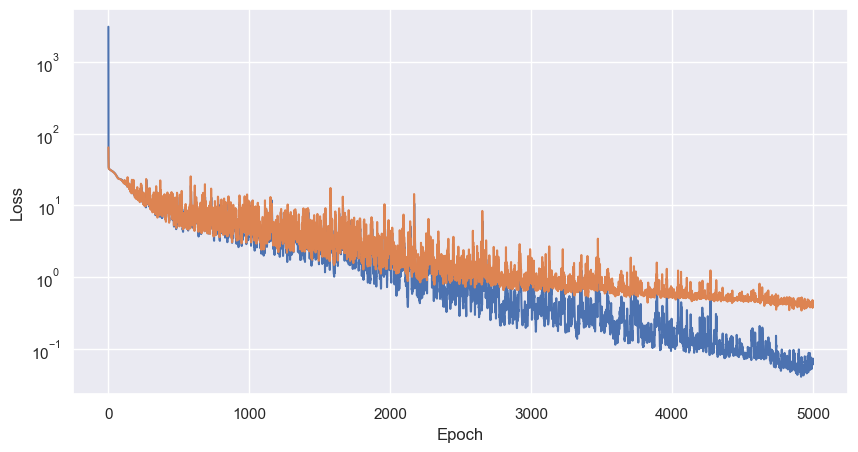

In [53]:
# Training configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move model to the appropriate device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
lr_set = 0.005
optimizer = optim.Adam(model.parameters(), lr=lr_set, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=80, factor=0.9, verbose=True)

# Training parameters
num_epochs = 5000
best_val_loss = float('inf')
early_stop_patience = 1500
early_stop_counter = 0
history = {'train_loss': [], 'val_loss': []}

# Initialize wandb for experiment tracking
wandb.init(project="ttf-prediction", name="encoder-operator-model-bedrock")
wandb.config.update({
    "epochs": num_epochs,
    "batch_size": batch_size,
    "optimizer": "Adam",
    "learning_rate": lr_set,
    "latent_dim": latent_dim,
    "input_size": input_size,
    "output_size": output_size,
    "fno_modes": fno_modes,
    "fno_width": fno_width,
    "fno_channels": fno_channels,
    "dropout_rate": dropout_rate,
    "early_stop_patience": early_stop_patience,
})

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        with torch.autograd.set_detect_anomaly(True):
            loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)
    
    # Update learning rate scheduler
    scheduler.step(val_loss)
    
    # Log metrics
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    wandb.log({
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'learning_rate': optimizer.param_groups[0]['lr']
    })
    
    # Print progress
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, LR: {optimizer.param_groups[0]["lr"]:.2e}')
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_ttf_model_1s1b.pt')
        early_stop_counter = 0
        print(f'Model saved with validation loss: {val_loss:.6f}')
    else:
        early_stop_counter += 1
    
    # Early stopping
    if early_stop_counter >= early_stop_patience:
        print(f'Early stopping triggered after {epoch+1} epochs')
        break

wandb.finish()

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')

In [54]:
# Load best model for evaluation
model.load_state_dict(torch.load('best_ttf_model_1s1b.pt', weights_only=True))
model.eval()

# Compute predictions on the test setd
test_predictions = []
test_targets = []
test_inputs = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        
        # Store the predictions, targets, and inputs
        test_predictions.append(outputs.cpu().numpy())
        test_targets.append(targets.cpu().numpy())
        test_inputs.append(inputs.cpu().numpy())

# Concatenate the batches
test_predictions = np.vstack(test_predictions)
test_targets = np.vstack(test_targets)
test_inputs = np.vstack(test_inputs)

# Calculate test loss
test_loss = np.mean((test_predictions - test_targets)**2)
print(f'Test MSE Loss: {test_loss:.6f}')


Test MSE Loss: 0.252285


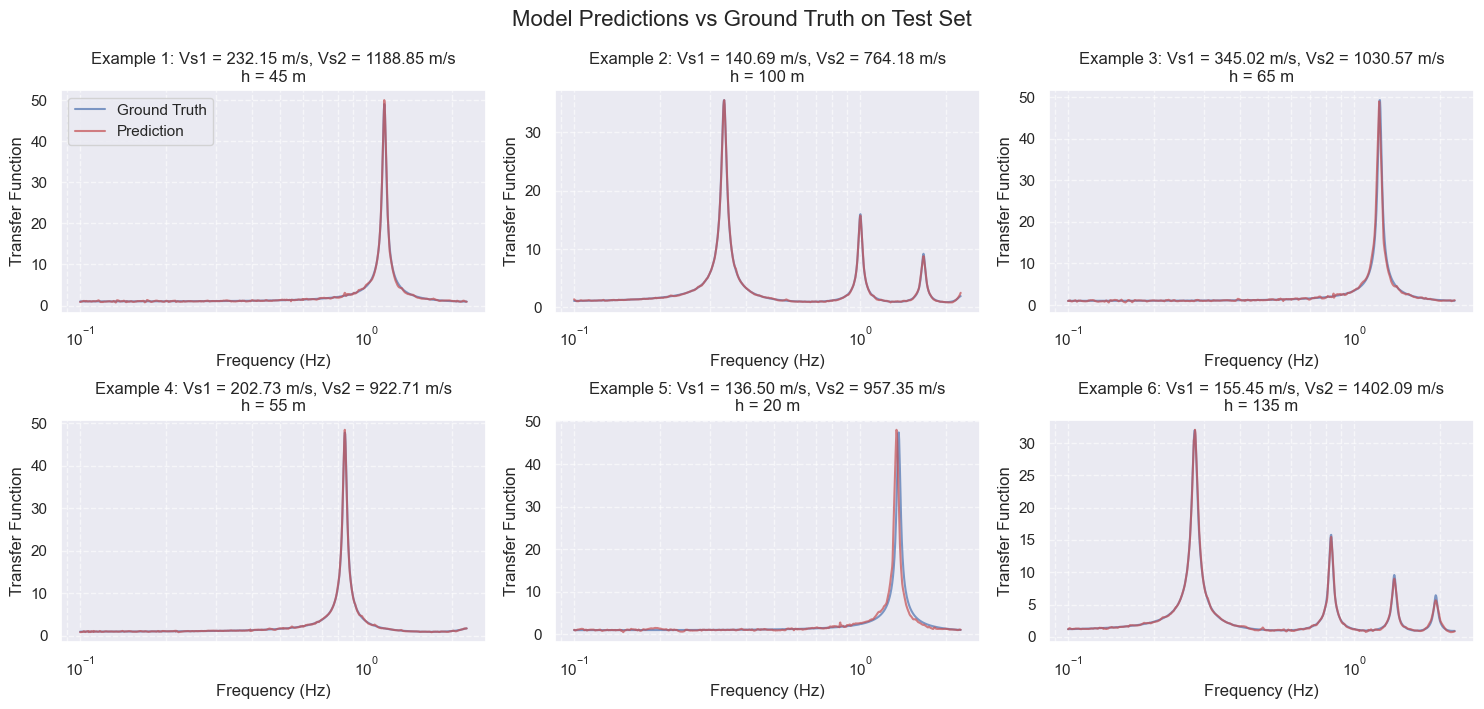

In [55]:
# Select 5 random indices from the test set
#np.random.seed(420)  # For reproducibility
random_indices = np.random.choice(len(test_predictions), 6, replace=False)

# Create a figure to plot the 5 random examples
plt.figure(figsize=(15, 10))

for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i+1)
    
    # Plot the target (ground truth)
    plt.plot(freq_data, test_targets[idx], 'b-', label='Ground Truth', alpha=0.7)
    
    # Plot the prediction
    plt.plot(freq_data, test_predictions[idx], 'r-', label='Prediction', alpha=0.7)
    
    # Show input Vs value
    
    vs_test = np.trim_zeros(test_inputs[idx], trim='b')
    vs_value_1 = vs_test[0]
    vs_value_2 = vs_test[-1]
    h_soil = len(vs_test[:-1])*5
    plt.title(f'Example {i+1}: Vs1 = {vs_value_1:.2f} m/s, Vs2 = {vs_value_2:.2f} m/s\nh = {h_soil:.0f} m')
    
    plt.xscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    
    # Only add legend to the first subplot
    if i == 0:
        plt.legend()
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Transfer Function')

plt.tight_layout()
plt.suptitle('Model Predictions vs Ground Truth on Test Set', fontsize=16)
plt.subplots_adjust(top=0.9)
#plt.savefig('test_predictions.png', dpi=300)
plt.show()

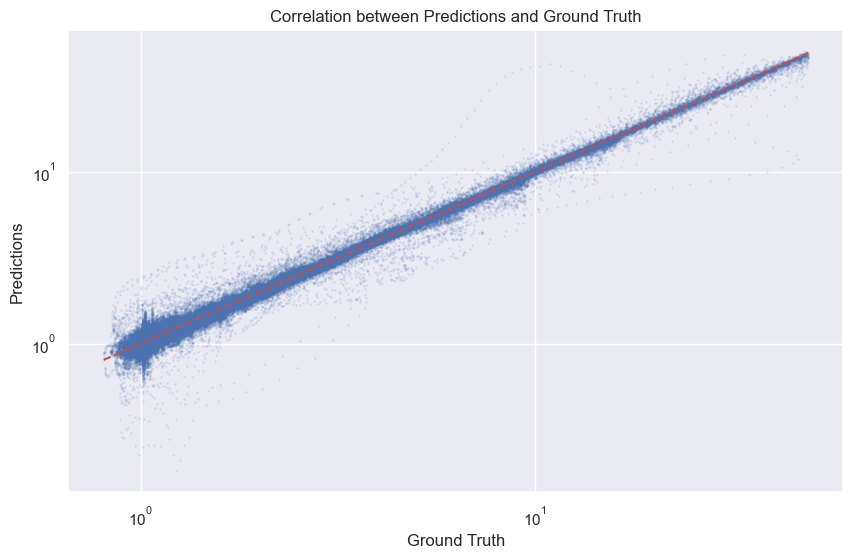

In [56]:
# Also plot the correlation between predictions and ground truth for all test samples
plt.figure(figsize=(10, 6))
plt.scatter(test_targets.flatten(), test_predictions.flatten(), alpha=0.1, s=1)
plt.plot([np.min(test_targets), np.max(test_targets)], 
         [np.min(test_targets), np.max(test_targets)], 'r--')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title('Correlation between Predictions and Ground Truth')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
#plt.savefig('prediction_correlation.png', dpi=300)
plt.show()

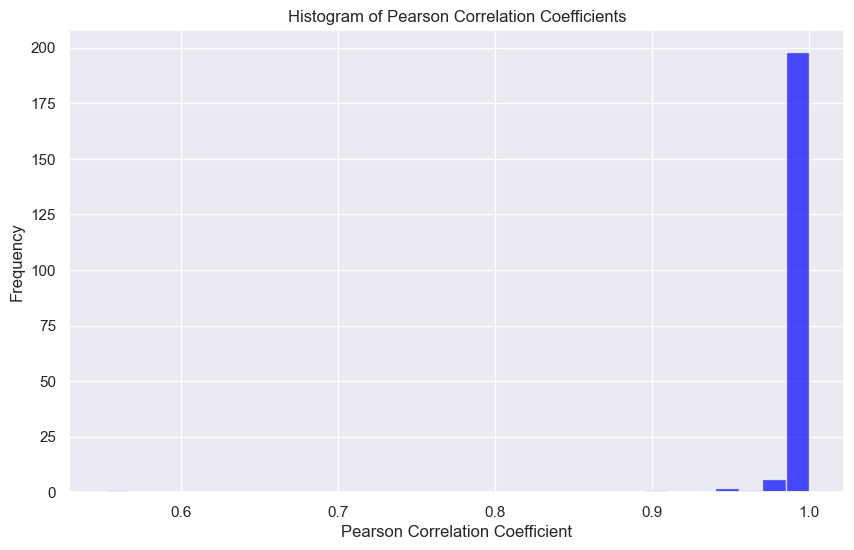

In [57]:
# Compute the pearson correlation coefficient
from scipy.stats import pearsonr

corr_coefficients = []
for i in range(len(test_predictions)):
    corr, _ = pearsonr(test_targets[i], test_predictions[i])
    corr_coefficients.append(corr)

# Plot the histogram of correlation coefficients
plt.figure(figsize=(10, 6))
plt.hist(corr_coefficients, bins=30, alpha=0.7, color='blue')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Frequency')
plt.title('Histogram of Pearson Correlation Coefficients')
plt.show()